In [ ]:
# !pip install kagglehub

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.environ["KAGGLEHUB_CACHE"] = "/content/drive/MyDrive/datasets/ecg_2023"

# import kagglehub

# path = kagglehub.dataset_download("drkhaledmohsin/national-heart-foundation-2023-ecg-dataset")
# print("Dataset saved to Google Drive:", path)

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

print("Google Drive connected successfully.")

Mounted at /content/drive
Google Drive connected successfully.


In [ ]:
BASE_DATA_PATH = "/content/drive/MyDrive/datasets/ecg_2023/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data"
PROCESSED_DATA_PATH = "/content/drive/MyDrive/datasets/ecg_2023/processed_data"

os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

print(f"Source data path: {BASE_DATA_PATH}")
print(f"Destination folder for processed data: {PROCESSED_DATA_PATH}")

if not os.path.exists(BASE_DATA_PATH):
    print("\nWARNING: The source data path was not found. Please check the BASE_DATA_PATH variable.")
else:
    print("\nDataset path found.")

Source data path: /content/drive/MyDrive/datasets/ecg_2023/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data
Destination folder for processed data: /content/drive/MyDrive/datasets/ecg_2023/processed_data

Dataset path found.


Using precise coordinates for cropping: {'y_start': 288, 'y_end': 1510, 'x_start': 73, 'x_end': 2171}
Using manual binarization threshold: 35
Found an image for demonstration: /content/drive/MyDrive/datasets/ecg_2023/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/Abnormal Heartbeat Patients/HB(1) - Copy.jpg



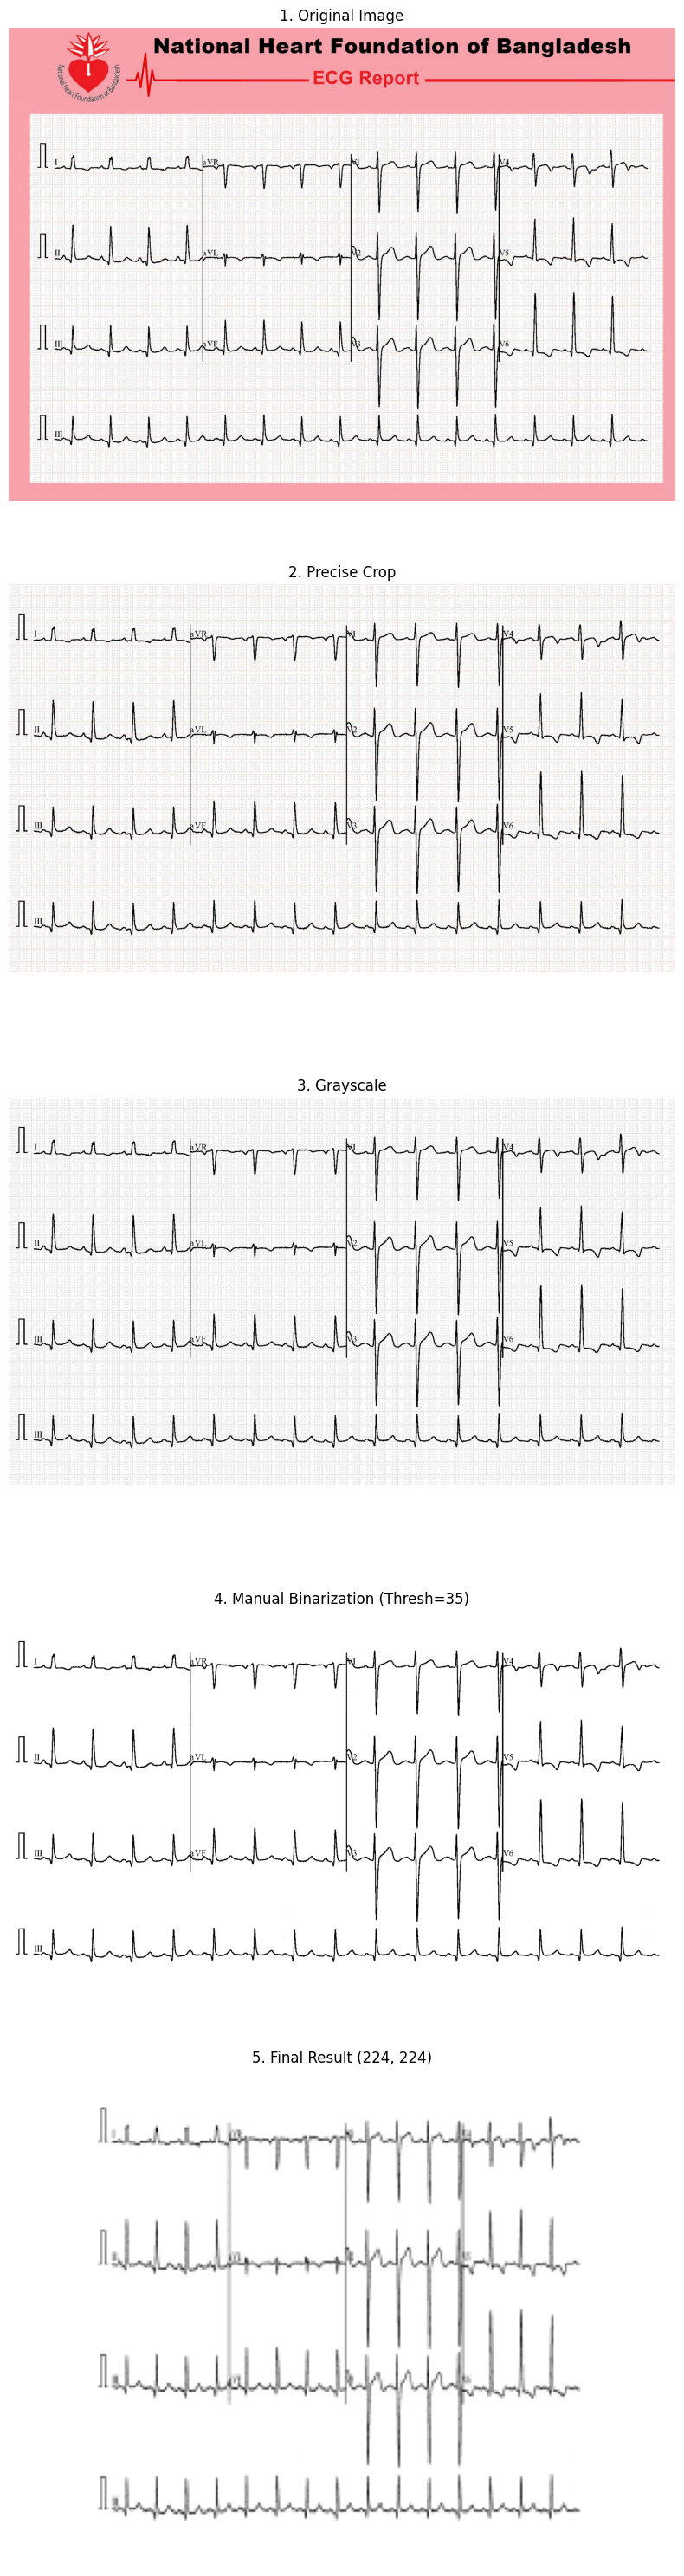

In [ ]:
CROP_COORDINATES = {
    'y_start': 288,
    'y_end': 1510,
    'x_start': 73,
    'x_end': 2171
}

BINARIZATION_THRESHOLD = 35

print(f"Using precise coordinates for cropping: {CROP_COORDINATES}")
print(f"Using manual binarization threshold: {BINARIZATION_THRESHOLD}")

def show_image(image, title, cmap=None):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')

example_image_path = None
for root, _, files in os.walk(BASE_DATA_PATH):
    if files:
        test_path = os.path.join(BASE_DATA_PATH, files[0])
        if os.path.exists(test_path):
             example_image_path = test_path
        else:
             example_image_path = os.path.join(root, files[0])
        break

if example_image_path:
    print(f"Found an image for demonstration: {example_image_path}\n")

    original_image = cv2.imread(example_image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    y1, y2 = CROP_COORDINATES['y_start'], CROP_COORDINATES['y_end']
    x1, x2 = CROP_COORDINATES['x_start'], CROP_COORDINATES['x_end']
    cropped_image = original_image[y1:y2, x1:x2]
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(gray_image, BINARIZATION_THRESHOLD, 255, cv2.THRESH_BINARY)

    output_size=(224, 224)
    resized_image = cv2.resize(binary_image, output_size, interpolation=cv2.INTER_AREA)

    plt.figure(figsize=(8, 30))

    plt.subplot(5, 1, 1)
    show_image(original_image_rgb, "1. Original Image")

    plt.subplot(5, 1, 2)
    show_image(cropped_image_rgb, "2. Precise Crop")

    plt.subplot(5, 1, 3)
    show_image(gray_image, "3. Grayscale", cmap='gray')

    plt.subplot(5, 1, 4)
    show_image(binary_image, f"4. Manual Binarization (Thresh={BINARIZATION_THRESHOLD})", cmap='gray')

    plt.subplot(5, 1, 5)
    show_image(resized_image, f"5. Final Result {output_size}", cmap='gray')

    plt.tight_layout()
    plt.show()

else:
    print("Could not find any images in the dataset. Please check the path.")


In [ ]:
def split_data(source_dir, train_ratio=0.8, val_ratio=0.1):
    """
    Scans the source directory, filters out duplicates, splits the file paths
    into train, validation, and test sets, and returns a dictionary of these splits.
    """
    print("\nScanning, filtering duplicates, and splitting data...")

    class_files = {}

    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        files_in_class = []
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and "copy" not in filename.lower():
                files_in_class.append(os.path.join(class_dir, filename))

        random.shuffle(files_in_class)
        class_files[class_name] = files_in_class

    splits = {'train': {}, 'val': {}, 'test': {}}

    for class_name, files in class_files.items():
        num_files = len(files)
        train_end = int(num_files * train_ratio)
        val_end = train_end + int(num_files * val_ratio)

        splits['train'][class_name] = files[:train_end]
        splits['val'][class_name] = files[train_end:val_end]
        splits['test'][class_name] = files[val_end:]

        print(f"Class '{class_name}': {num_files} total -> "
              f"{len(splits['train'][class_name])} train, "
              f"{len(splits['val'][class_name])} val, "
              f"{len(splits['test'][class_name])} test.")

    print("Data splitting complete.")
    return splits

# data_splits = split_data(BASE_DATA_PATH)

In [ ]:
def preprocess_and_save(image_path, crop_coords, binarization_thresh):
    """Performs all preprocessing steps for a single image WITHOUT the final resize."""
    image = cv2.imread(image_path)
    if image is None: return None
    y1, y2 = crop_coords['y_start'], crop_coords['y_end']
    x1, x2 = crop_coords['x_start'], crop_coords['x_end']
    img_h, img_w, _ = image.shape
    cropped_image = image[y1:y2, x1:x2] if y2 <= img_h and x2 <= img_w else image
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, binarization_thresh, 255, cv2.THRESH_BINARY)
    return binary_image

def process_dataset_from_splits(splits, destination_path, crop_coords, binarization_thresh):
    """
    Iterates through the dictionary of splits, processes each image, and saves it
    to the correct train/val/test destination folder.
    """
    print("\nStarting full dataset processing based on splits...")

    # Iterate through train, val, test sets
    for split_name, class_data in splits.items():

        # Use tqdm for progress bar
        progress_bar = tqdm(total=sum(len(files) for files in class_data.values()),
                            desc=f"Processing '{split_name}'")

        # Iterate through class names (e.g., 'Normal Person')
        for class_name, file_paths in class_data.items():

            # Create the destination directory
            output_class_path = os.path.join(destination_path, split_name, class_name)
            os.makedirs(output_class_path, exist_ok=True)

            # Process and save each file
            for image_path in file_paths:
                processed_image = preprocess_and_save(image_path, crop_coords, binarization_thresh)

                if processed_image is not None:
                    filename = os.path.basename(image_path)
                    output_filename = os.path.join(output_class_path, filename)
                    cv2.imwrite(output_filename, processed_image)

                progress_bar.update(1)
        progress_bar.close()

    print("\nAll datasets processed and saved into train/val/test folders successfully!")

In [ ]:
# Process all images using the generated splits and save them
# process_dataset_from_splits(data_splits, PROCESSED_DATA_PATH, CROP_COORDINATES, 35)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# --- GLOBAL PARAMETERS ---
BATCH_SIZE = 32
# NEW: Increased epochs for better training
INITIAL_EPOCHS = 15 # Epochs for training the head
FINE_TUNE_EPOCHS = 10 # Epochs for fine-tuning
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

train_dir = os.path.join(PROCESSED_DATA_PATH, 'train')
NUM_CLASSES = len(os.listdir(train_dir))
CLASS_NAMES = sorted(os.listdir(train_dir))

print(f"Path to processed data: {PROCESSED_DATA_PATH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total epochs: {TOTAL_EPOCHS} ({INITIAL_EPOCHS} initial + {FINE_TUNE_EPOCHS} fine-tuning)")
print(f"Found {NUM_CLASSES} classes: {CLASS_NAMES}")

Path to processed data: /content/drive/MyDrive/datasets/ecg_2023/processed_data
Batch size: 32
Total epochs: 25 (15 initial + 10 fine-tuning)
Found 4 classes: ['Abnormal Heartbeat Patients', 'Myocardial Infarction Patients', 'Normal Person', 'Patient that have History of Myocardial Infraction']


In [ ]:
def load_datasets(image_size):
    """
    Loads the training, validation, and test datasets
    with dynamic image resizing.
    """
    print(f"\nLoading data with image size: {image_size}x{image_size}")

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(PROCESSED_DATA_PATH, 'train'),
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        color_mode='grayscale'
    ).cache().prefetch(buffer_size=AUTOTUNE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(PROCESSED_DATA_PATH, 'val'),
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        color_mode='grayscale'
    ).cache().prefetch(buffer_size=AUTOTUNE)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(PROCESSED_DATA_PATH, 'test'),
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False,
        color_mode='grayscale'
    ).cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds

In [ ]:
def build_model(model_name, input_size, num_classes):
    """
    Builds a transfer learning model with the corrected input layer logic.
    """
    # Define the input layer for our 1-channel images
    inputs = keras.Input(shape=(input_size, input_size, 1))

    # Layer to convert 1 channel to 3 channels (by duplication)
    x = layers.Conv2D(3, (1, 1), padding='same')(inputs)

    # Define the base model with a standard 3-channel input shape
    input_shape_3_channels = (input_size, input_size, 3)

    if model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(input_shape=input_shape_3_channels, include_top=False, weights='imagenet')
    elif model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(input_shape=input_shape_3_channels, include_top=False, weights='imagenet')
    elif model_name == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(input_shape=input_shape_3_channels, include_top=False, weights='imagenet')
    elif model_name == 'EfficientNetB2':
        base_model = tf.keras.applications.EfficientNetB2(input_shape=(input_size, input_size, 3), include_top=False, weights='imagenet')
    elif model_name == 'EfficientNetB4':
        base_model = tf.keras.applications.EfficientNetB4(input_shape=(input_size, input_size, 3), include_top=False, weights='imagenet')
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Freeze the weights of the base model
    base_model.trainable = False

    # Connect our converted input to the base model
    x = base_model(x, training=False)

    # Add our custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x) # Dropout for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# --- Dictionary of models to train and their respective image sizes ---
MODELS_TO_TRAIN = {
    'VGG16': 224,
    'ResNet50': 224,
    'InceptionV3': 299,
    'EfficientNetB2': 260,
    'EfficientNetB4': 380
}

# Dictionary to store results
results = {}

# Main training loop
for model_name, img_size in MODELS_TO_TRAIN.items():
    print(f"\n{'='*20} TRAINING MODEL: {model_name} {'='*20}")

    start_time = time.time()

    # 1. Load data
    train_ds, val_ds, test_ds = load_datasets(img_size)

    # 2. Build model
    model = build_model(model_name, img_size, NUM_CLASSES)

    # --- STAGE 1: Train the head ---
    print(f"\n--- Stage 1: Training the classifier head for {INITIAL_EPOCHS} epochs ---")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=INITIAL_EPOCHS,
        verbose=1
    )

    # --- STAGE 2: Fine-Tuning ---
    base_model = model.layers[2]
    base_model.trainable = True

    fine_tune_at = int(len(base_model.layers) * 0.7)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n--- Stage 2: Fine-tuning the top layers for {FINE_TUNE_EPOCHS} epochs ---")
    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=TOTAL_EPOCHS,
        initial_epoch=history.epoch[-1]
    )

    # 4. Evaluate the fine-tuned model
    print(f"\nEvaluating fine-tuned {model_name} on test data...")
    test_loss, test_accuracy = model.evaluate(test_ds)

    end_time = time.time()
    total_training_time = end_time - start_time

    # 5. Save results
    history.epoch.extend(history_fine.epoch)
    for key in history.history:
        history.history[key].extend(history_fine.history[key])

    results[model_name] = {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'training_time': total_training_time
    }

print("\nAll models successfully fine-tuned and evaluated!")


==================== TRAINING MODEL: VGG16 ====================

Loading data with image size: 224x224
Found 1103 files belonging to 4 classes.
Found 135 files belonging to 4 classes.
Found 143 files belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

--- Stage 1: Training the classifier head for 15 epochs ---
Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 273s 7s/step - accuracy: 0.2575 - loss: 5.8957 - val_accuracy: 0.4148 - val_loss: 1.7833
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.2940 - loss: 3.6780 - val_accuracy: 0.5630 - val_loss: 1.1241
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - accuracy: 0.3876 - loss: 2.4296 - val_accuracy: 0.6741 - val_loss: 0.8934
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - accuracy: 0.4292 - loss: 1.7004 - val_accuracy: 0.7630 - val_loss: 0.7473
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.4929 - loss: 1.3418 - val_accuracy: 0.7407 - val_loss: 0.7261
Epoch 6/15
35/35 ━━━


==================== EVALUATION FOR: VGG16 ====================

Loading data with image size: 224x224
Found 1103 files belonging to 4 classes.
Found 135 files belonging to 4 classes.
Found 143 files belonging to 4 classes.
Generating predictions on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step

--- Classification Report ---
Overall Accuracy: 0.979 (97.9%)


precision  recall  \
Abnormal Heartbeat Patients                             0.972   1.000   
Myocardial Infarction Patients                          1.000   1.000   
Normal Person                                           0.957   1.000   
Patient that have History of Myocardial Infraction      1.000   0.889   
macro avg                                               0.982   0.972   
weighted avg                                            0.980   0.979   

                                                    f1-score  support  
Abnormal Heartbeat Patients                            0.986       35  
Myocardial Infarction Patients                         1.000       37  
Normal Person                                          0.978       44  
Patient that have History of Myocardial Infraction     0.941       27  
macro avg                                              0.976      143  
weighted avg                                           0.979      143


--- Confusion Matrix ---


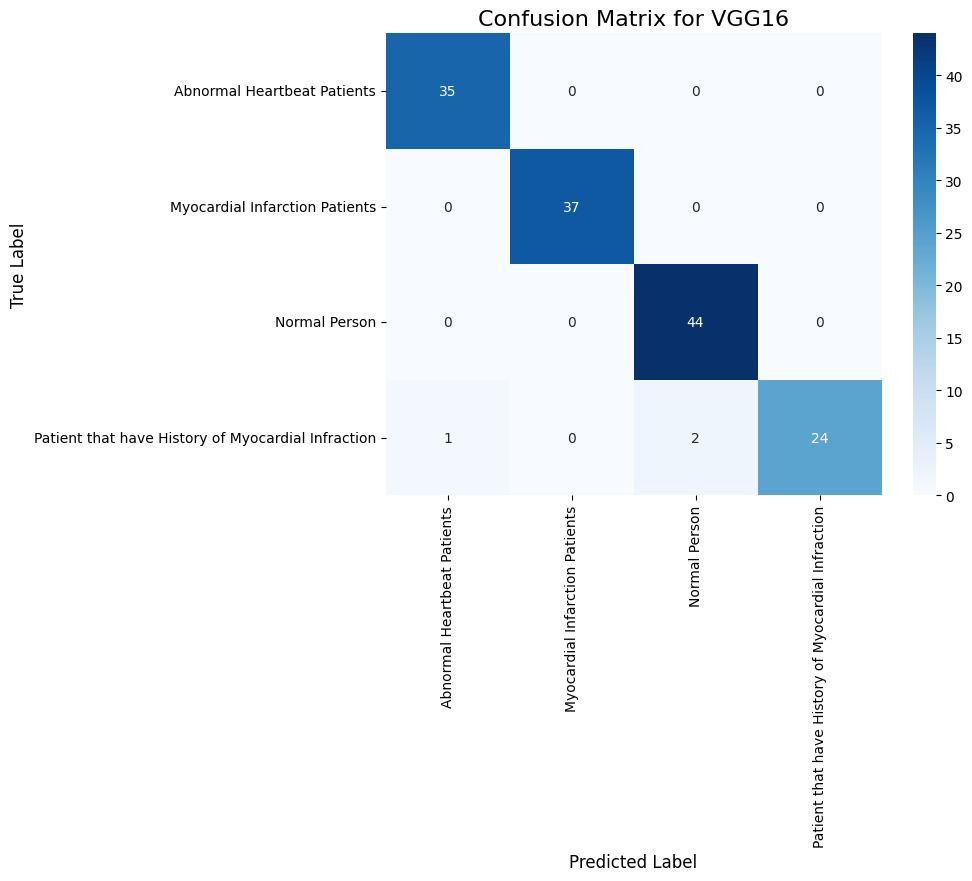


==================== EVALUATION FOR: ResNet50 ====================

Loading data with image size: 224x224
Found 1103 files belonging to 4 classes.
Found 135 files belonging to 4 classes.
Found 143 files belonging to 4 classes.
Generating predictions on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

--- Classification Report ---
Overall Accuracy: 0.993 (99.3%)


precision  recall  \
Abnormal Heartbeat Patients                             1.000   0.971   
Myocardial Infarction Patients                          0.974   1.000   
Normal Person                                           1.000   1.000   
Patient that have History of Myocardial Infraction      1.000   1.000   
macro avg                                               0.993   0.993   
weighted avg                                            0.993   0.993   

                                                    f1-score  support  
Abnormal Heartbeat Patients                            0.986       35  
Myocardial Infarction Patients                         0.987       37  
Normal Person                                          1.000       44  
Patient that have History of Myocardial Infraction     1.000       27  
macro avg                                              0.993      143  
weighted avg                                           0.993      143


--- Confusion Matrix ---


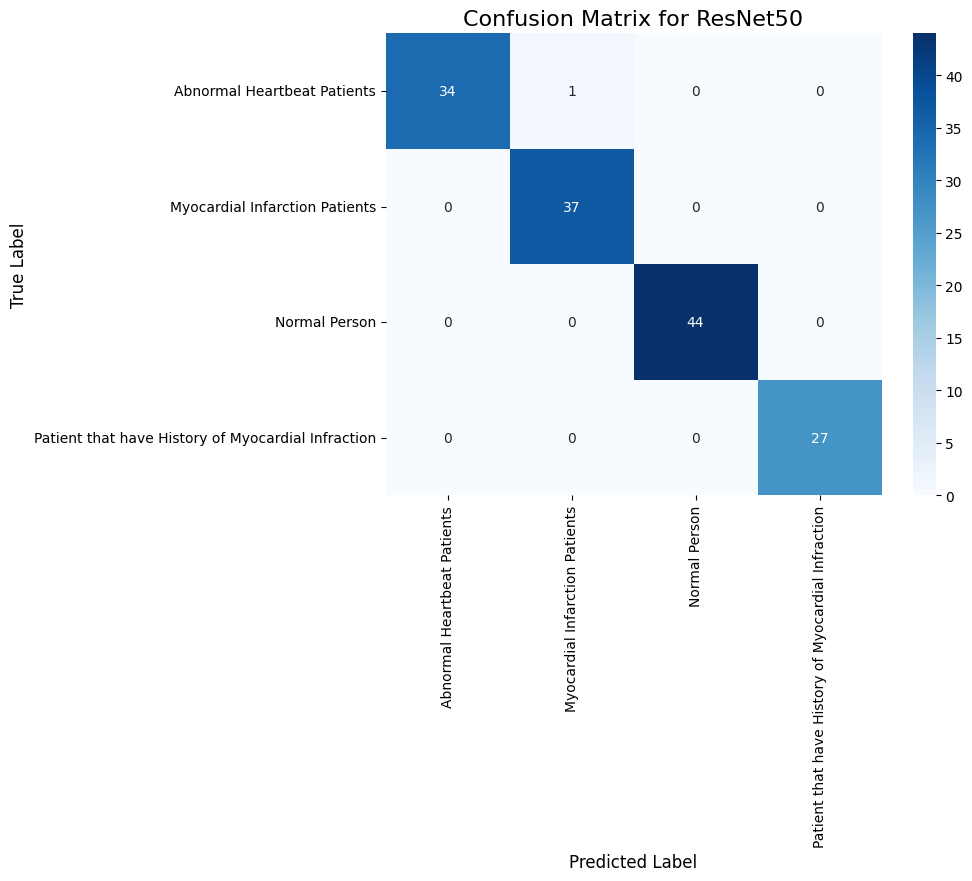


==================== EVALUATION FOR: InceptionV3 ====================

Loading data with image size: 299x299
Found 1103 files belonging to 4 classes.
Found 135 files belonging to 4 classes.
Found 143 files belonging to 4 classes.
Generating predictions on the test set...


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

--- Classification Report ---
Overall Accuracy: 0.972 (97.2%)


precision  recall  \
Abnormal Heartbeat Patients                             0.971   0.943   
Myocardial Infarction Patients                          1.000   1.000   
Normal Person                                           0.936   1.000   
Patient that have History of Myocardial Infraction      1.000   0.926   
macro avg                                               0.977   0.967   
weighted avg                                            0.973   0.972   

                                                    f1-score  support  
Abnormal Heartbeat Patients                            0.957       35  
Myocardial Infarction Patients                         1.000       37  
Normal Person                                          0.967       44  
Patient that have History of Myocardial Infraction     0.962       27  
macro avg                                              0.971      143  
weighted avg                                           0.972      143


--- Confusion Matrix ---


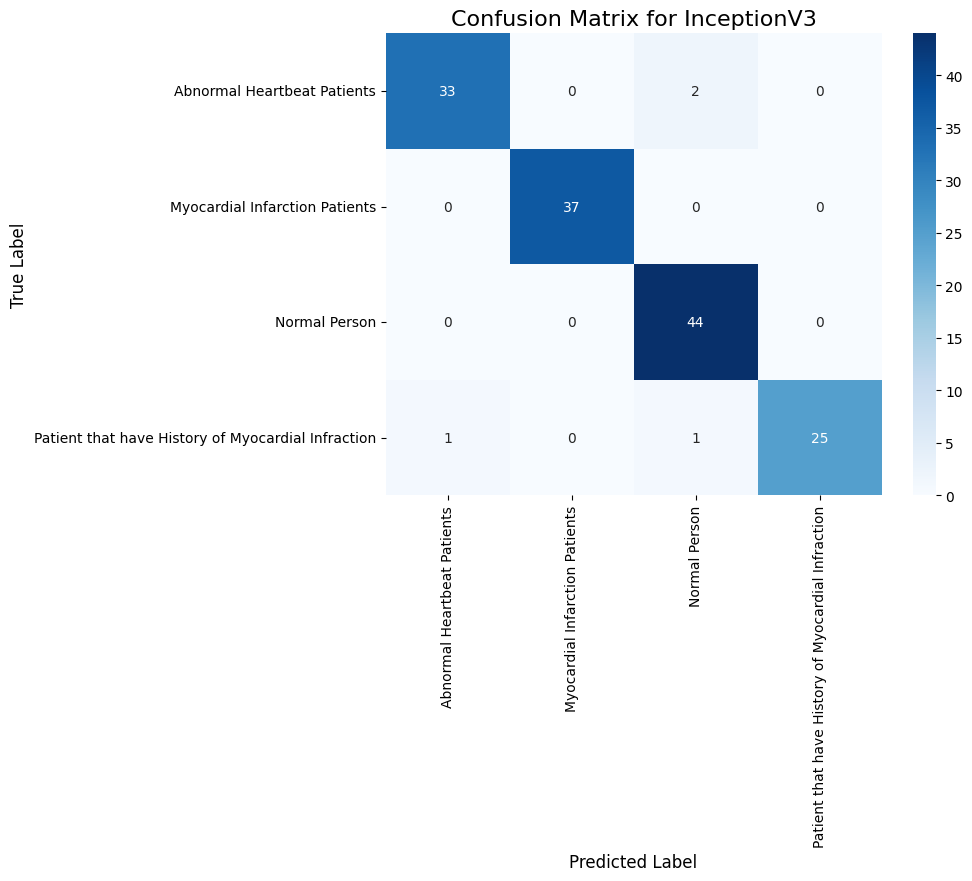


==================== EVALUATION FOR: EfficientNetB2 ====================

Loading data with image size: 260x260
Found 1103 files belonging to 4 classes.
Found 135 files belonging to 4 classes.
Found 143 files belonging to 4 classes.
Generating predictions on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step

--- Classification Report ---
Overall Accuracy: 0.825 (82.5%)


precision  recall  \
Abnormal Heartbeat Patients                             0.848   0.800   
Myocardial Infarction Patients                          0.968   0.811   
Normal Person                                           0.712   0.955   
Patient that have History of Myocardial Infraction      0.900   0.667   
macro avg                                               0.857   0.808   
weighted avg                                            0.847   0.825   

                                                    f1-score  support  
Abnormal Heartbeat Patients                            0.824       35  
Myocardial Infarction Patients                         0.882       37  
Normal Person                                          0.816       44  
Patient that have History of Myocardial Infraction     0.766       27  
macro avg                                              0.822      143  
weighted avg                                           0.825      143


--- Confusion Matrix ---


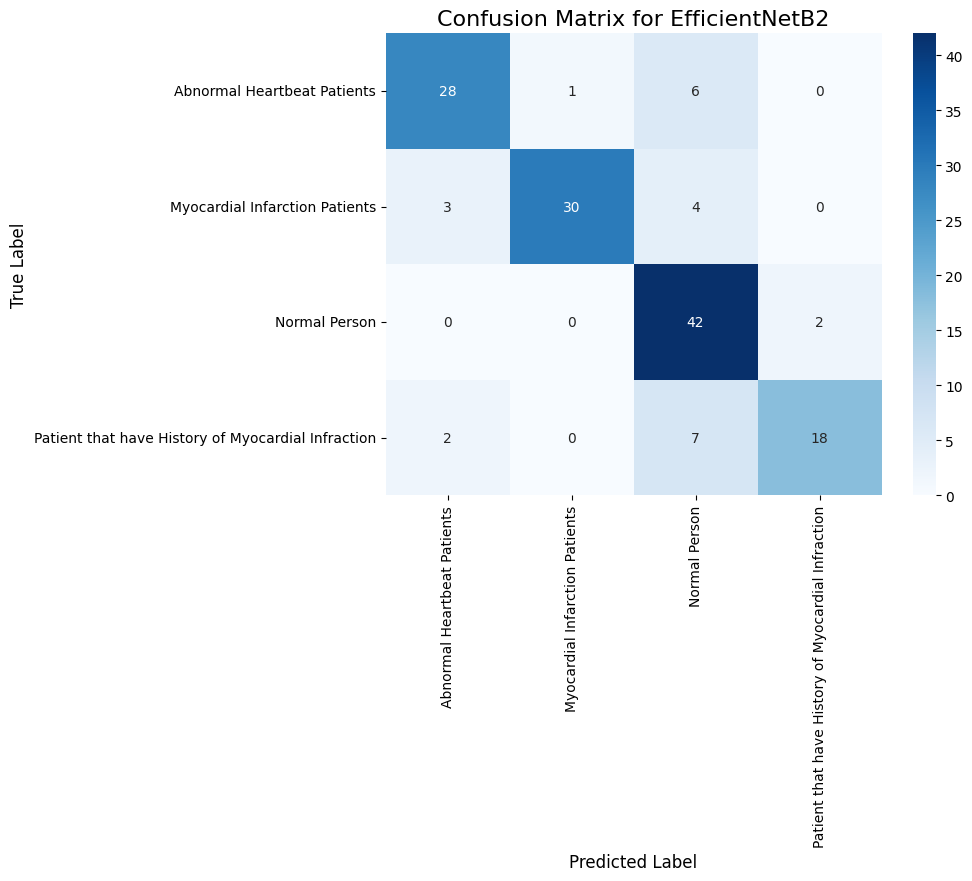


==================== EVALUATION FOR: EfficientNetB4 ====================

Loading data with image size: 380x380
Found 1103 files belonging to 4 classes.
Found 135 files belonging to 4 classes.
Found 143 files belonging to 4 classes.
Generating predictions on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step

--- Classification Report ---
Overall Accuracy: 0.818 (81.8%)


precision  recall  \
Abnormal Heartbeat Patients                             0.906   0.829   
Myocardial Infarction Patients                          1.000   0.784   
Normal Person                                           0.721   1.000   
Patient that have History of Myocardial Infraction      0.714   0.556   
macro avg                                               0.835   0.792   
weighted avg                                            0.837   0.818   

                                                    f1-score  support  
Abnormal Heartbeat Patients                            0.866       35  
Myocardial Infarction Patients                         0.879       37  
Normal Person                                          0.838       44  
Patient that have History of Myocardial Infraction     0.625       27  
macro avg                                              0.802      143  
weighted avg                                           0.815      143


--- Confusion Matrix ---


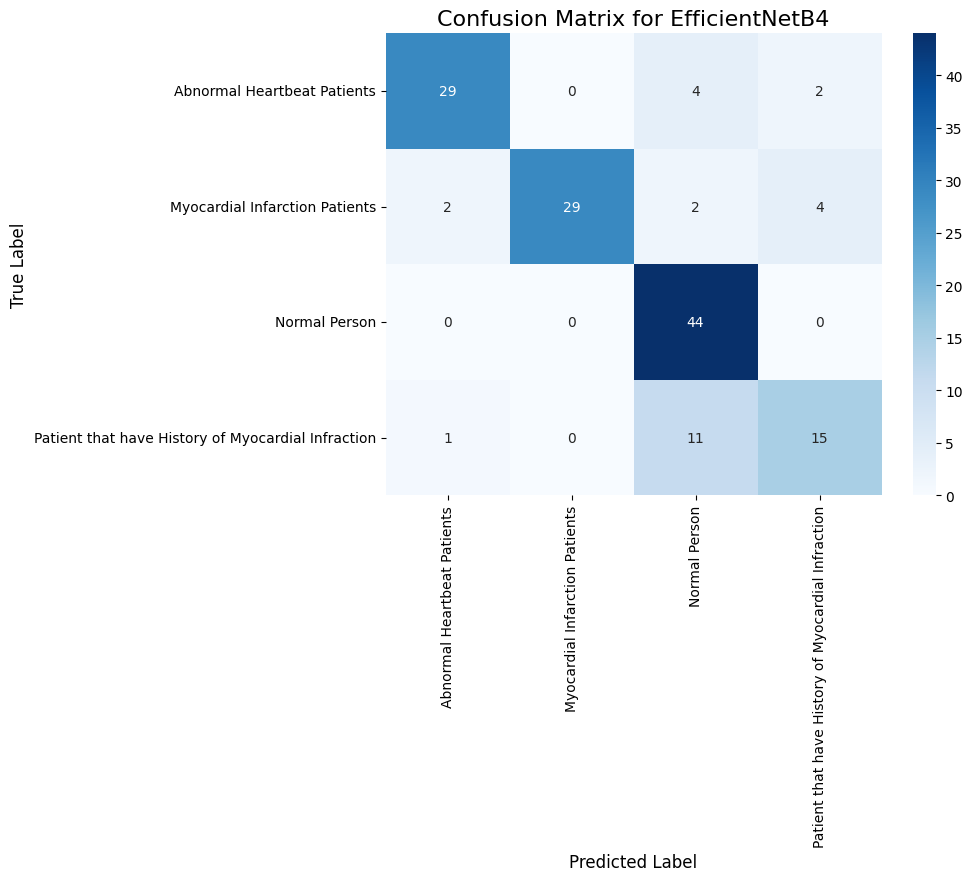


==================== FINAL METRICS COMPARISON ====================


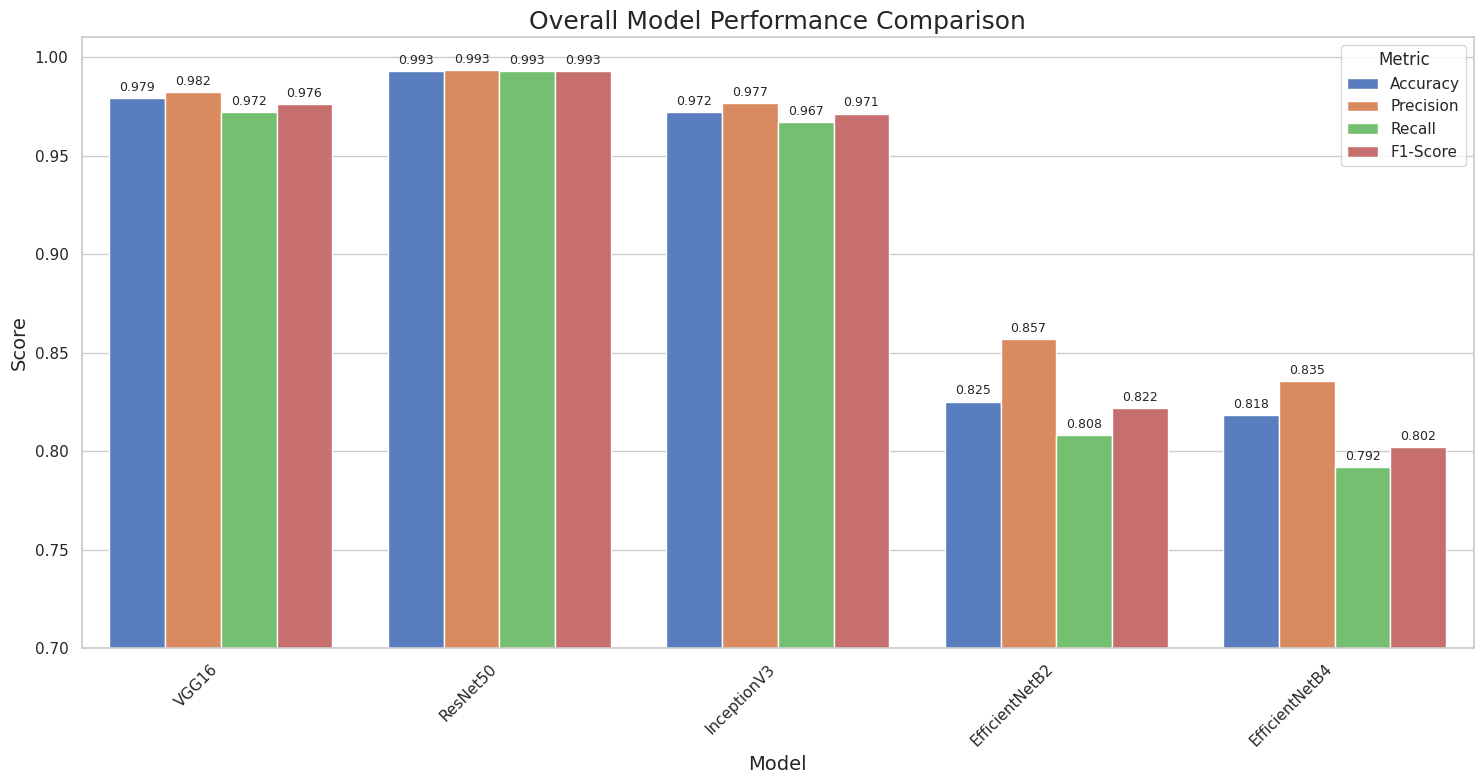


==================== TRAINING TIME COMPARISON ====================


/tmp/ipython-input-3727177685.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


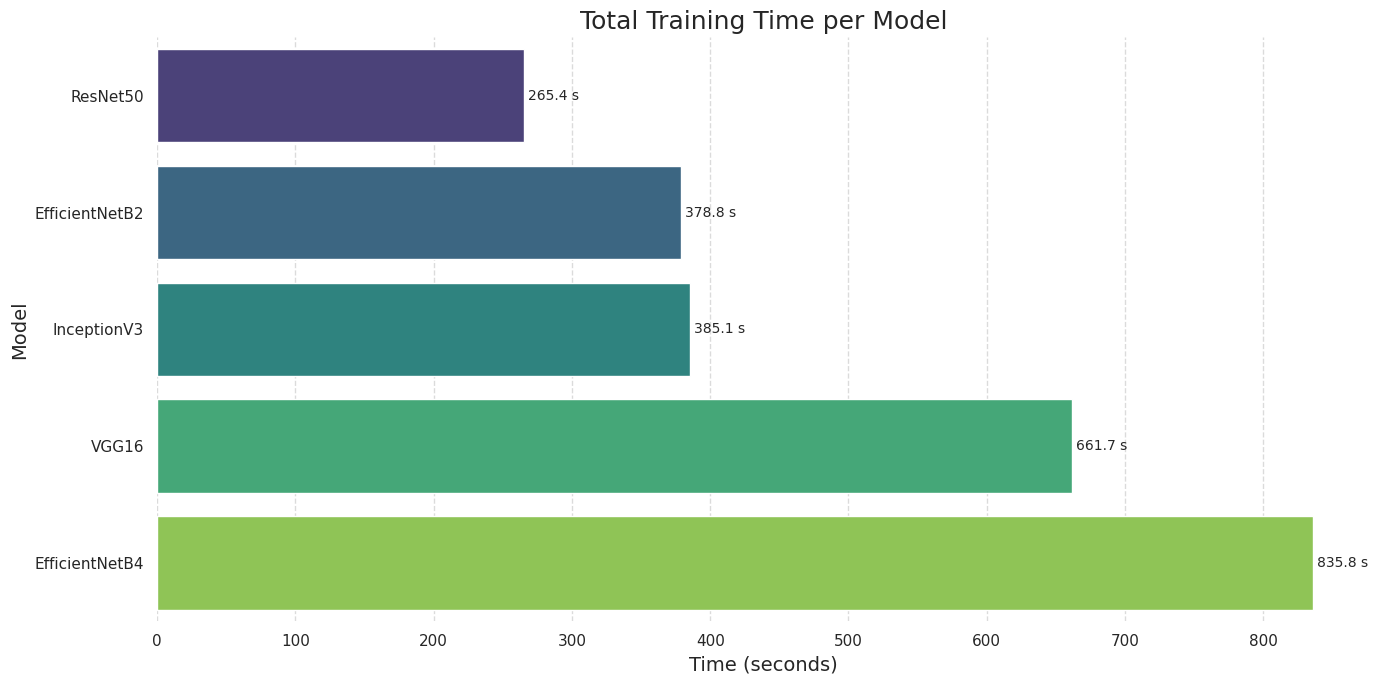

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

# --- Create a list to store detailed metrics for the final summary plot ---
report_data = []

# --- Loop through each trained model in the results dictionary ---
for model_name, result_data in results.items():
    print(f"\n{'='*20} EVALUATION FOR: {model_name} {'='*20}")

    model = result_data['model']
    img_size = MODELS_TO_TRAIN[model_name]
    _, _, test_ds = load_datasets(img_size)

    print("Generating predictions on the test set...")
    y_pred_probs = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true_classes = np.argmax(y_true, axis=1)

    # --- 1. Classification Report (Accuracy, Precision, Recall, F1-score) ---
    print("\n--- Classification Report ---")
    report = classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES, output_dict=True)

    accuracy = report['accuracy']

    report_df = pd.DataFrame(report).transpose().drop('accuracy')

    report_df['support'] = report_df['support'].astype(int)
    report_df = report_df.round(3)

    print(f"Overall Accuracy: {accuracy:.3f} ({(accuracy * 100):.1f}%)")

    display(report_df)

    # Save the main metrics for the final plot
    report_data.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1-Score': report['macro avg']['f1-score'],
        'Training Time': result_data.get('training_time', 0)
    })

    # --- 2. Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()


# --- 3. Final Metrics Comparison Bar Chart---
print(f"\n{'='*20} FINAL METRICS COMPARISON {'='*20}")
summary_df = pd.DataFrame(report_data)

sns.set_theme(style="whitegrid")

summary_melted = summary_df.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(15, 8))
ax = sns.barplot(
    data=summary_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette='muted'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

plt.title('Overall Model Performance Comparison', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.01)
plt.legend(loc='upper right', title='Metric')
plt.tight_layout()
plt.show()


# --- 4. TRAINING TIME COMPARISON CHART---
print(f"\n{'='*20} TRAINING TIME COMPARISON {'='*20}")

summary_df_sorted_by_time = summary_df.sort_values(by='Training Time')

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=summary_df_sorted_by_time,
    x='Training Time',
    y='Model',
    palette='viridis'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f s', fontsize=10, padding=3)

plt.title('Total Training Time per Model', fontsize=18)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Model', fontsize=14)

sns.despine(bottom=True, left=True)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Automatically selecting top 2 models based on test accuracy...
Selected models for visualization: ['ResNet50', 'VGG16']
Grouping processed test images by class...
Found test images for 4 classes.

========================= ANALYSIS FOR CLASS: 'Abnormal Heartbeat Patients' =========================
Analyzing image: HB(330).jpg


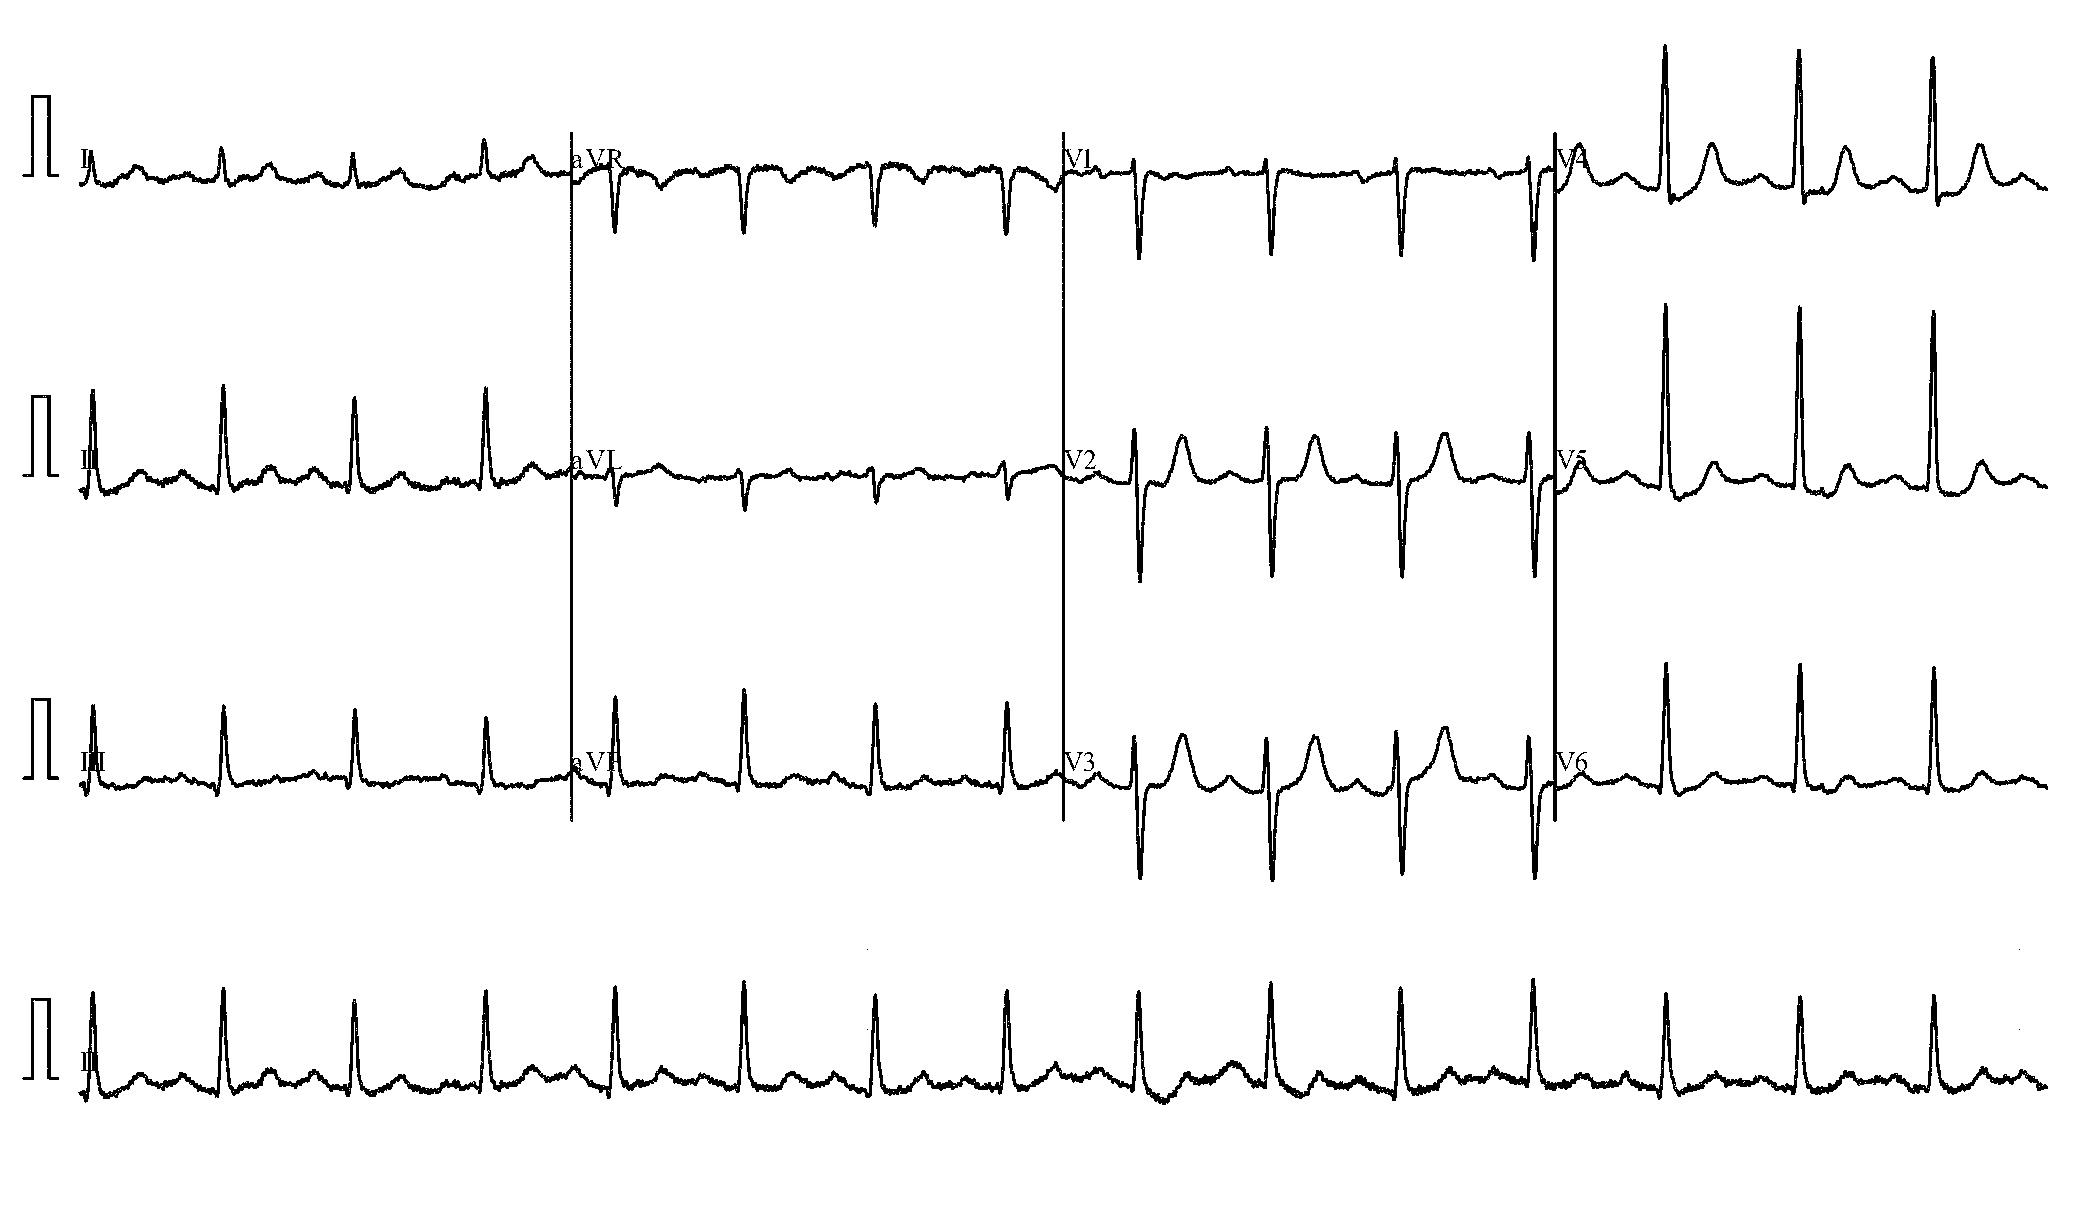

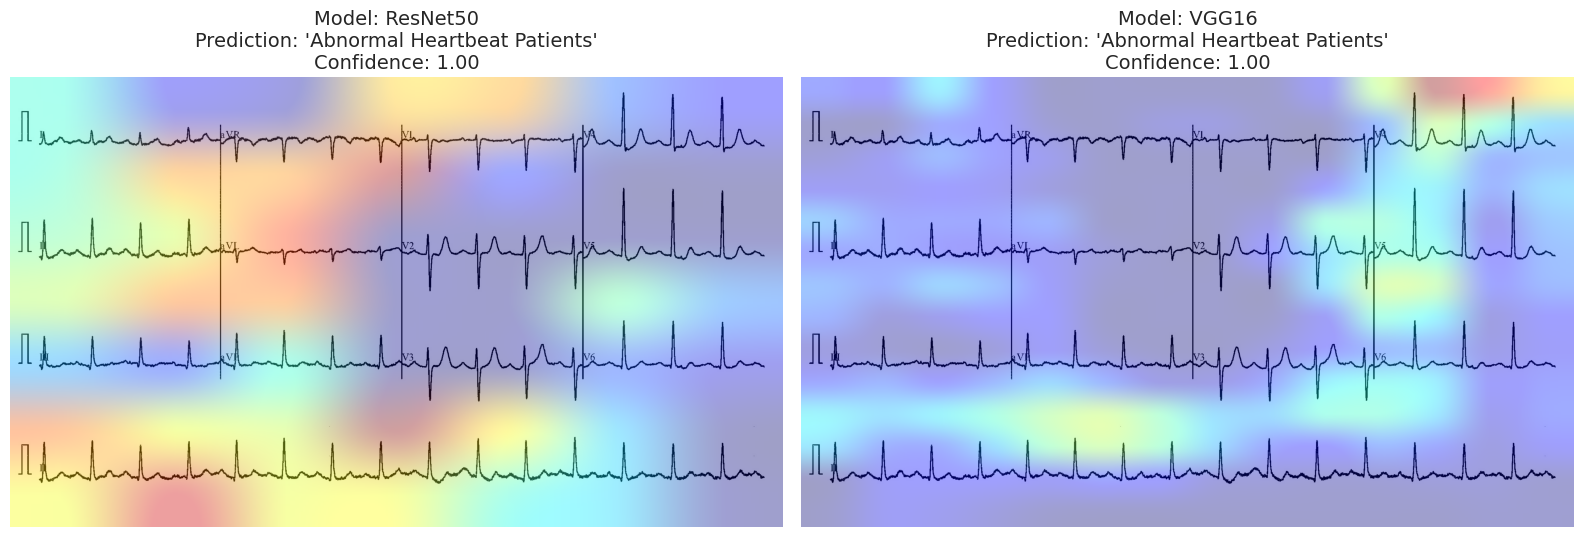


========================= ANALYSIS FOR CLASS: 'Myocardial Infarction Patients' =========================
Analyzing image: MI(69).jpg


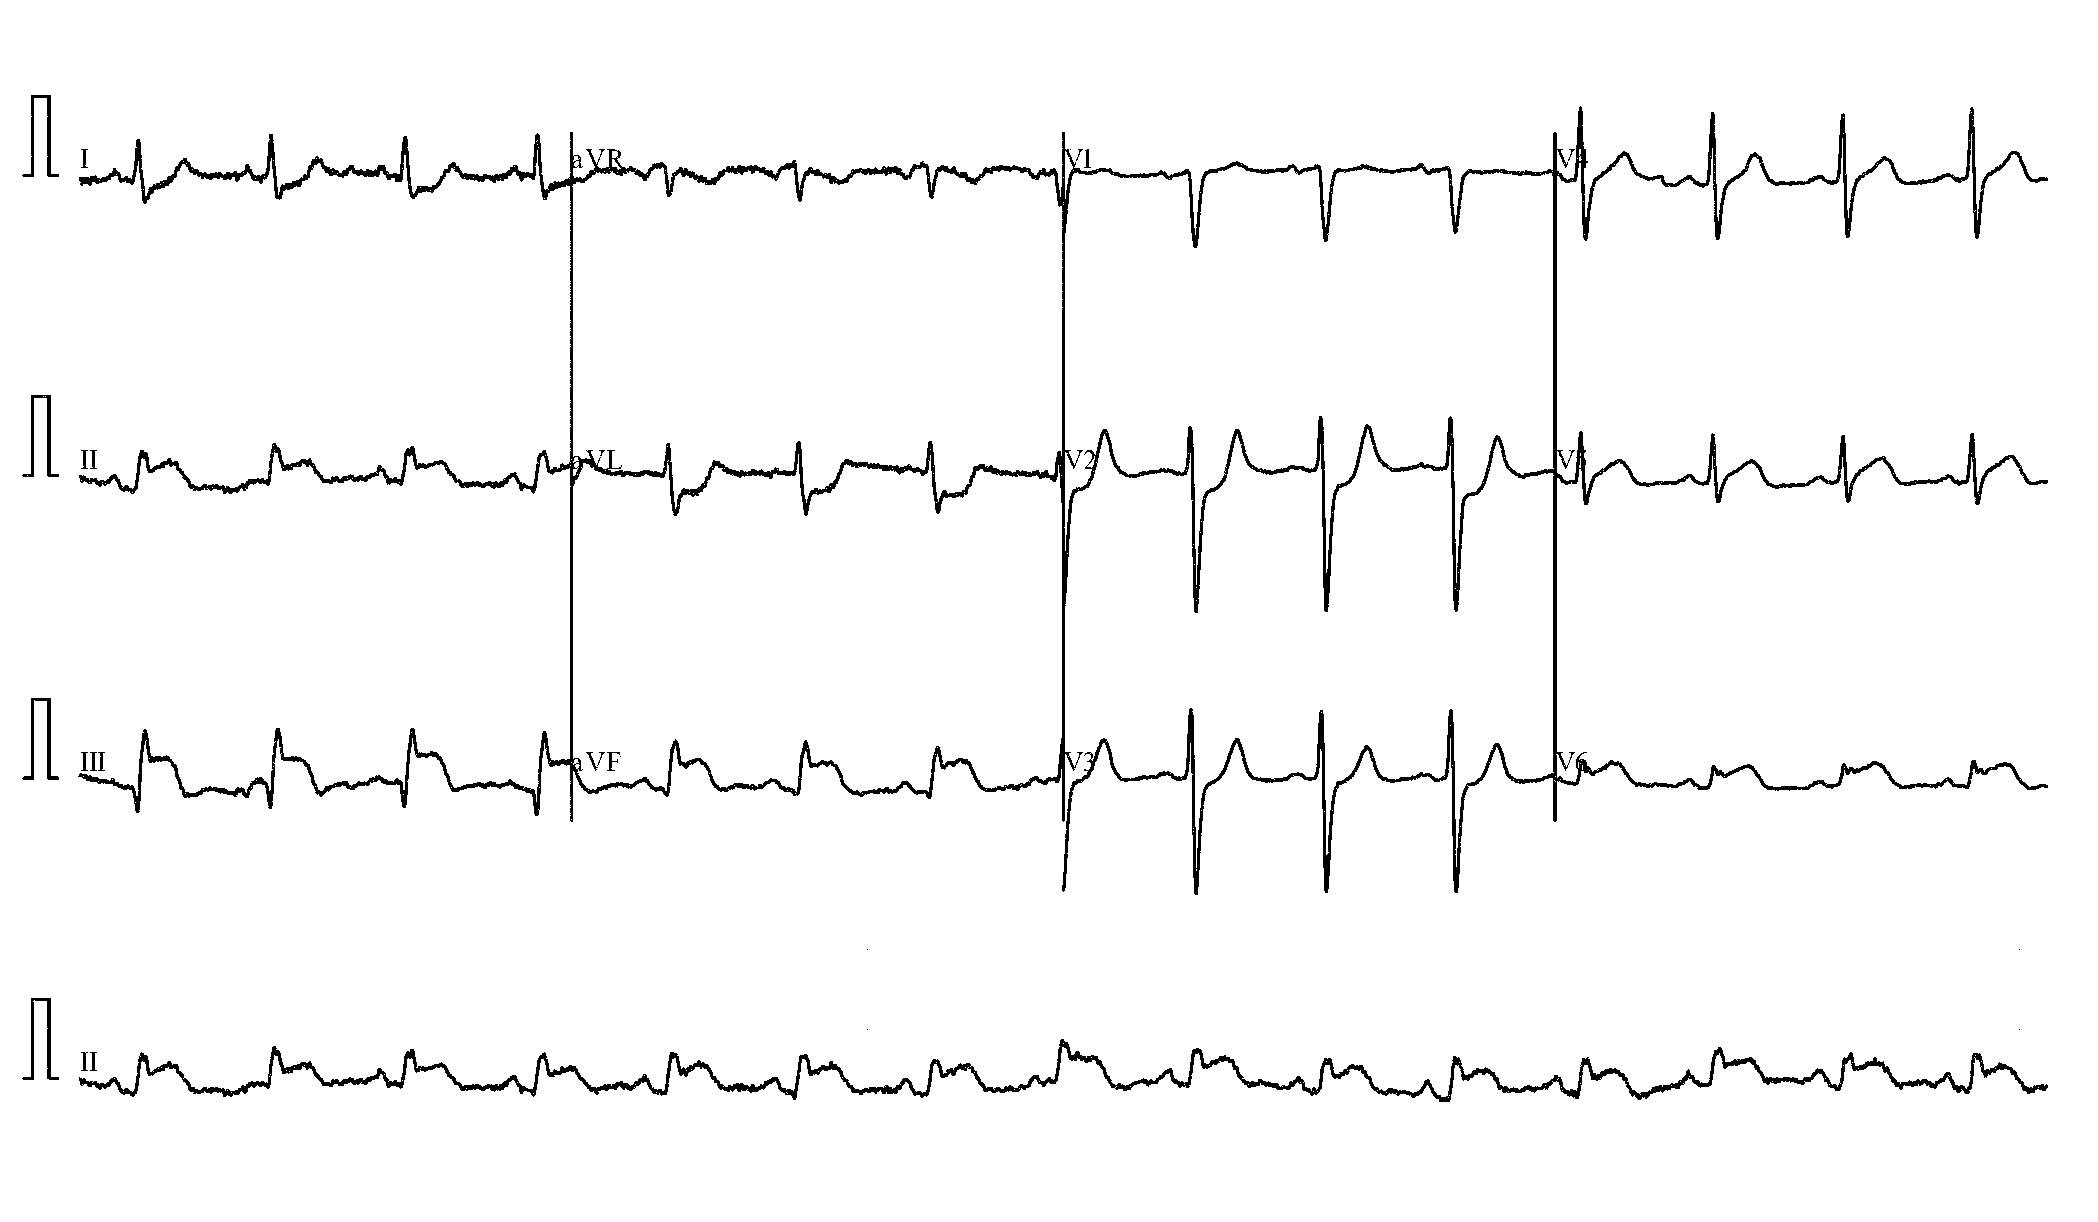

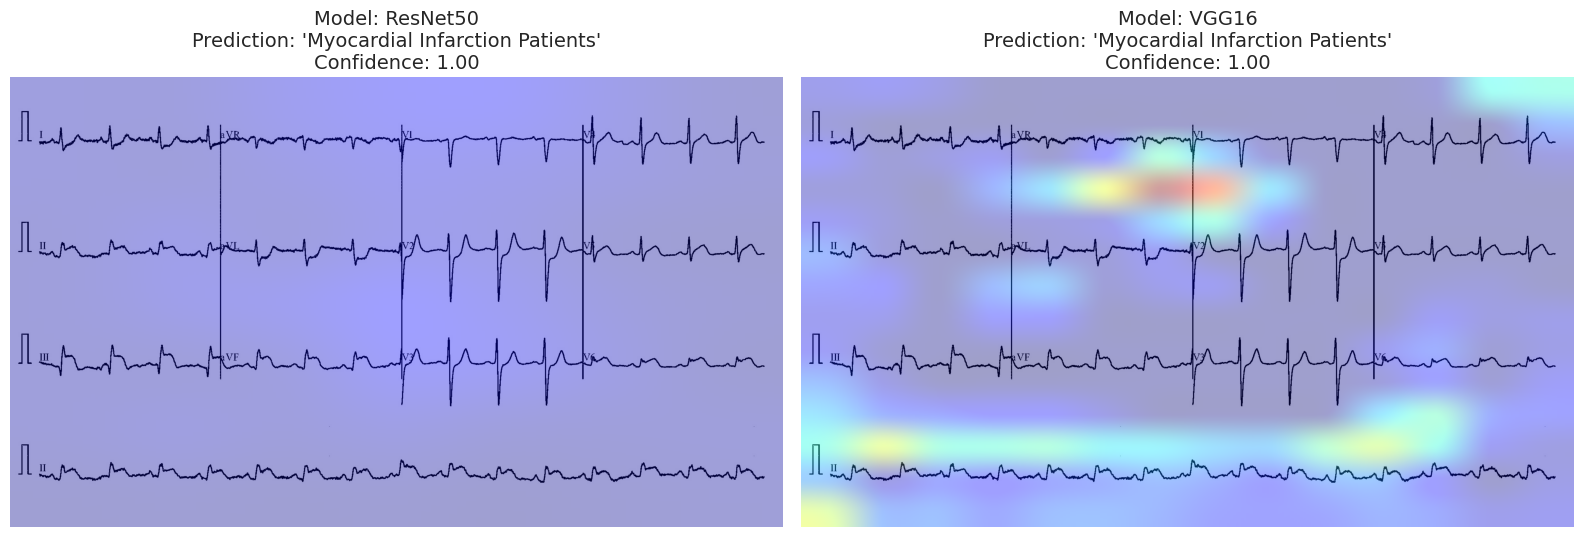


========================= ANALYSIS FOR CLASS: 'Normal Person' =========================
Analyzing image: Normal(241).jpg


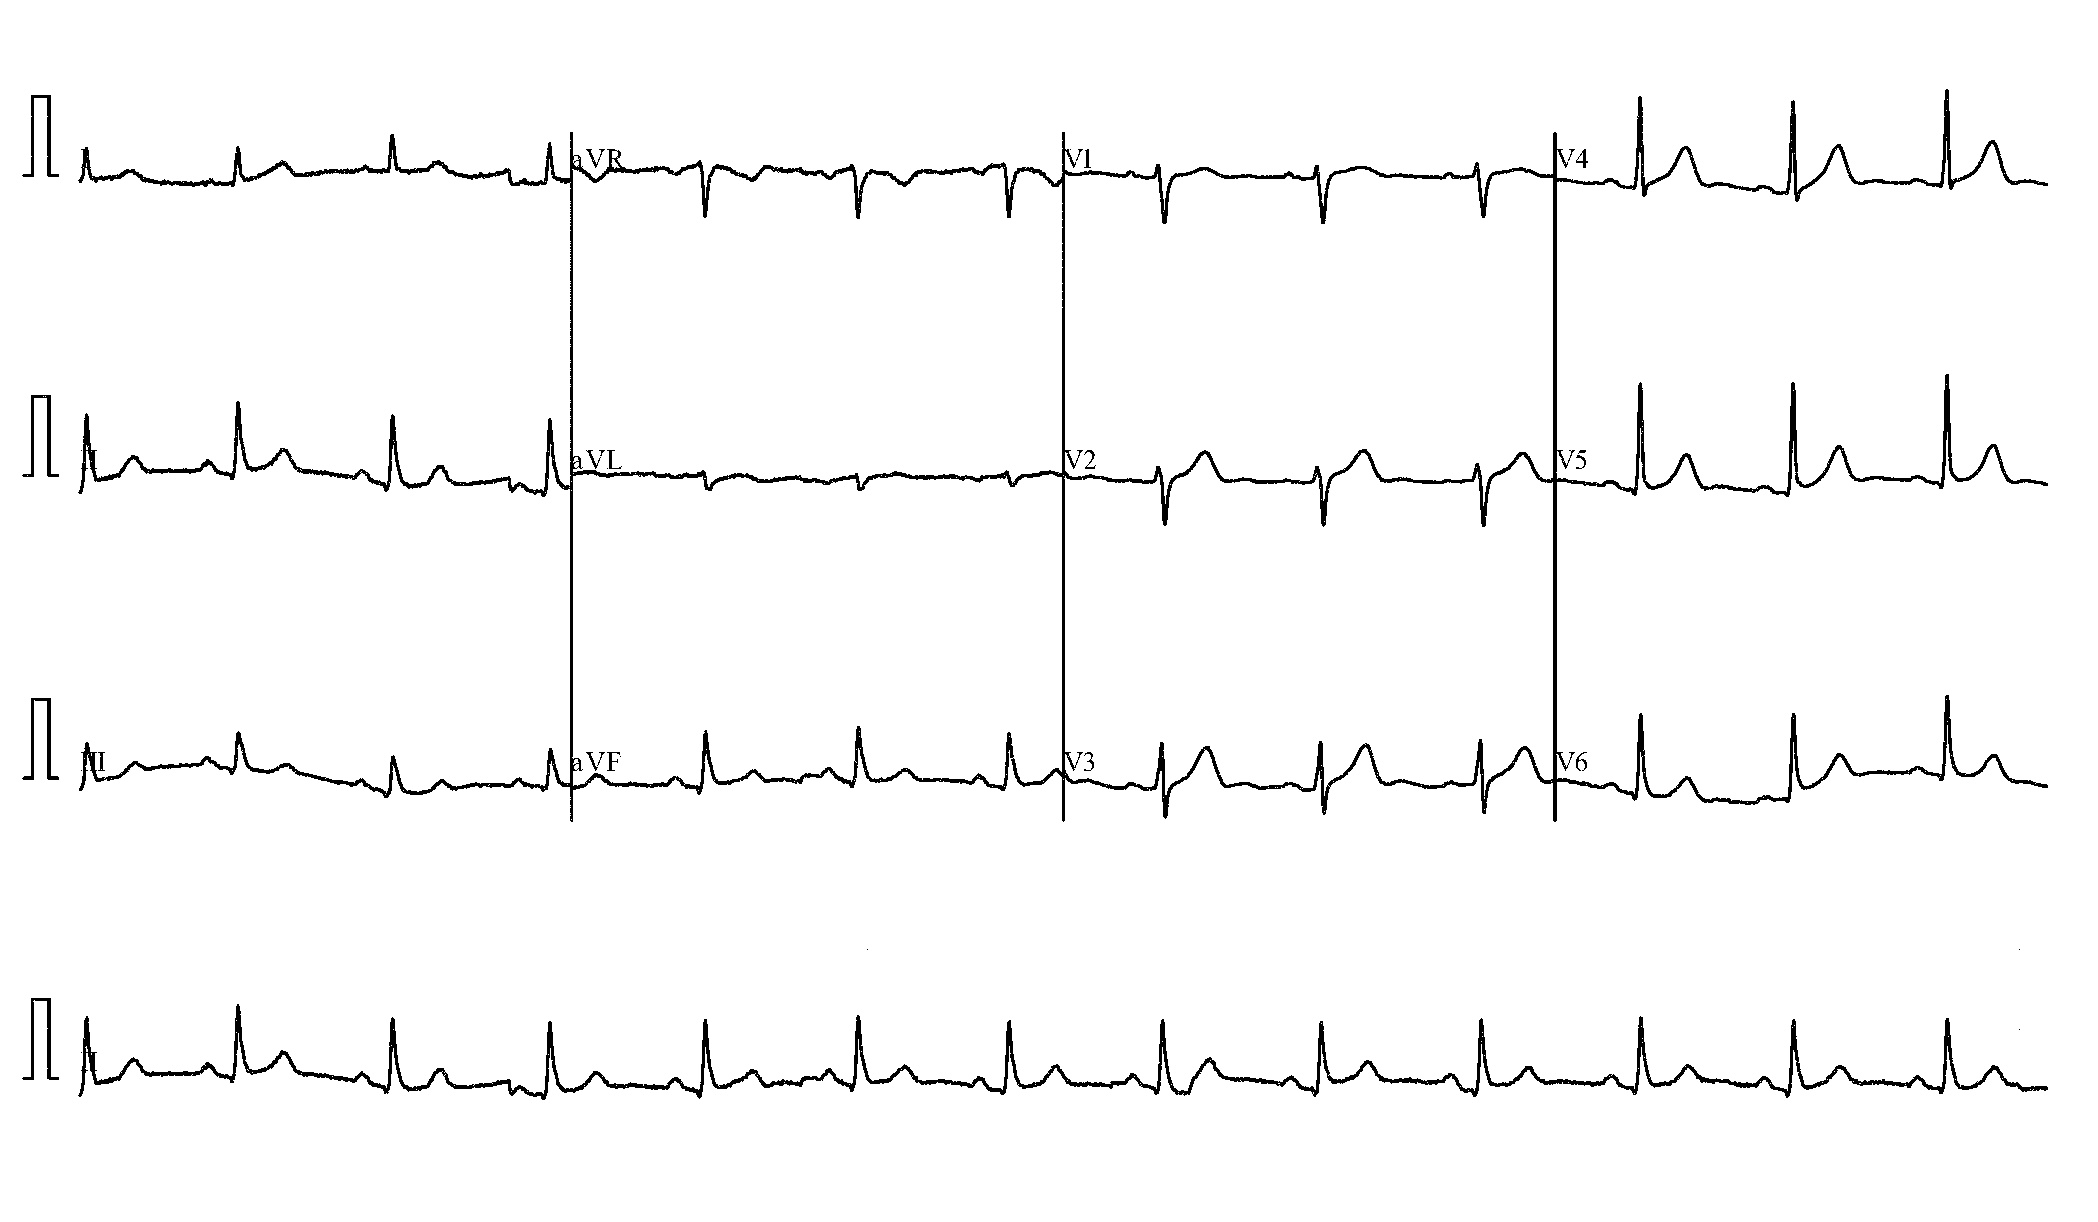

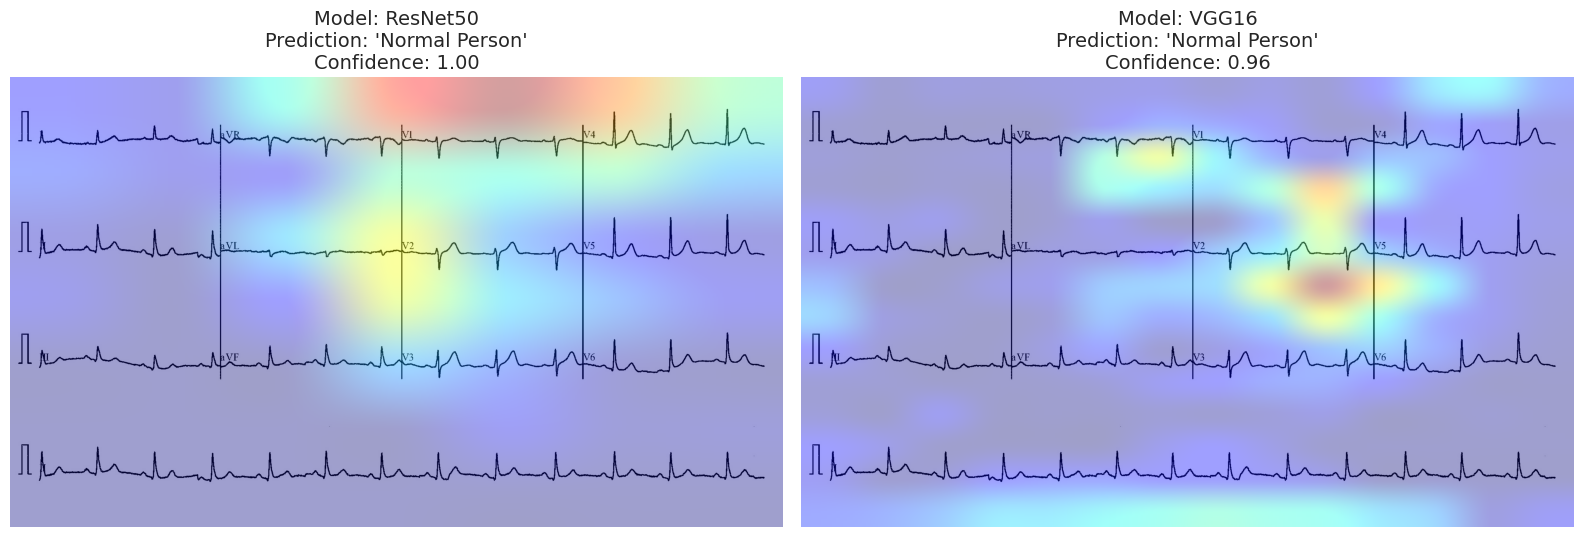


========================= ANALYSIS FOR CLASS: 'Patient that have History of Myocardial Infraction' =========================
Analyzing image: PMI(9).jpg


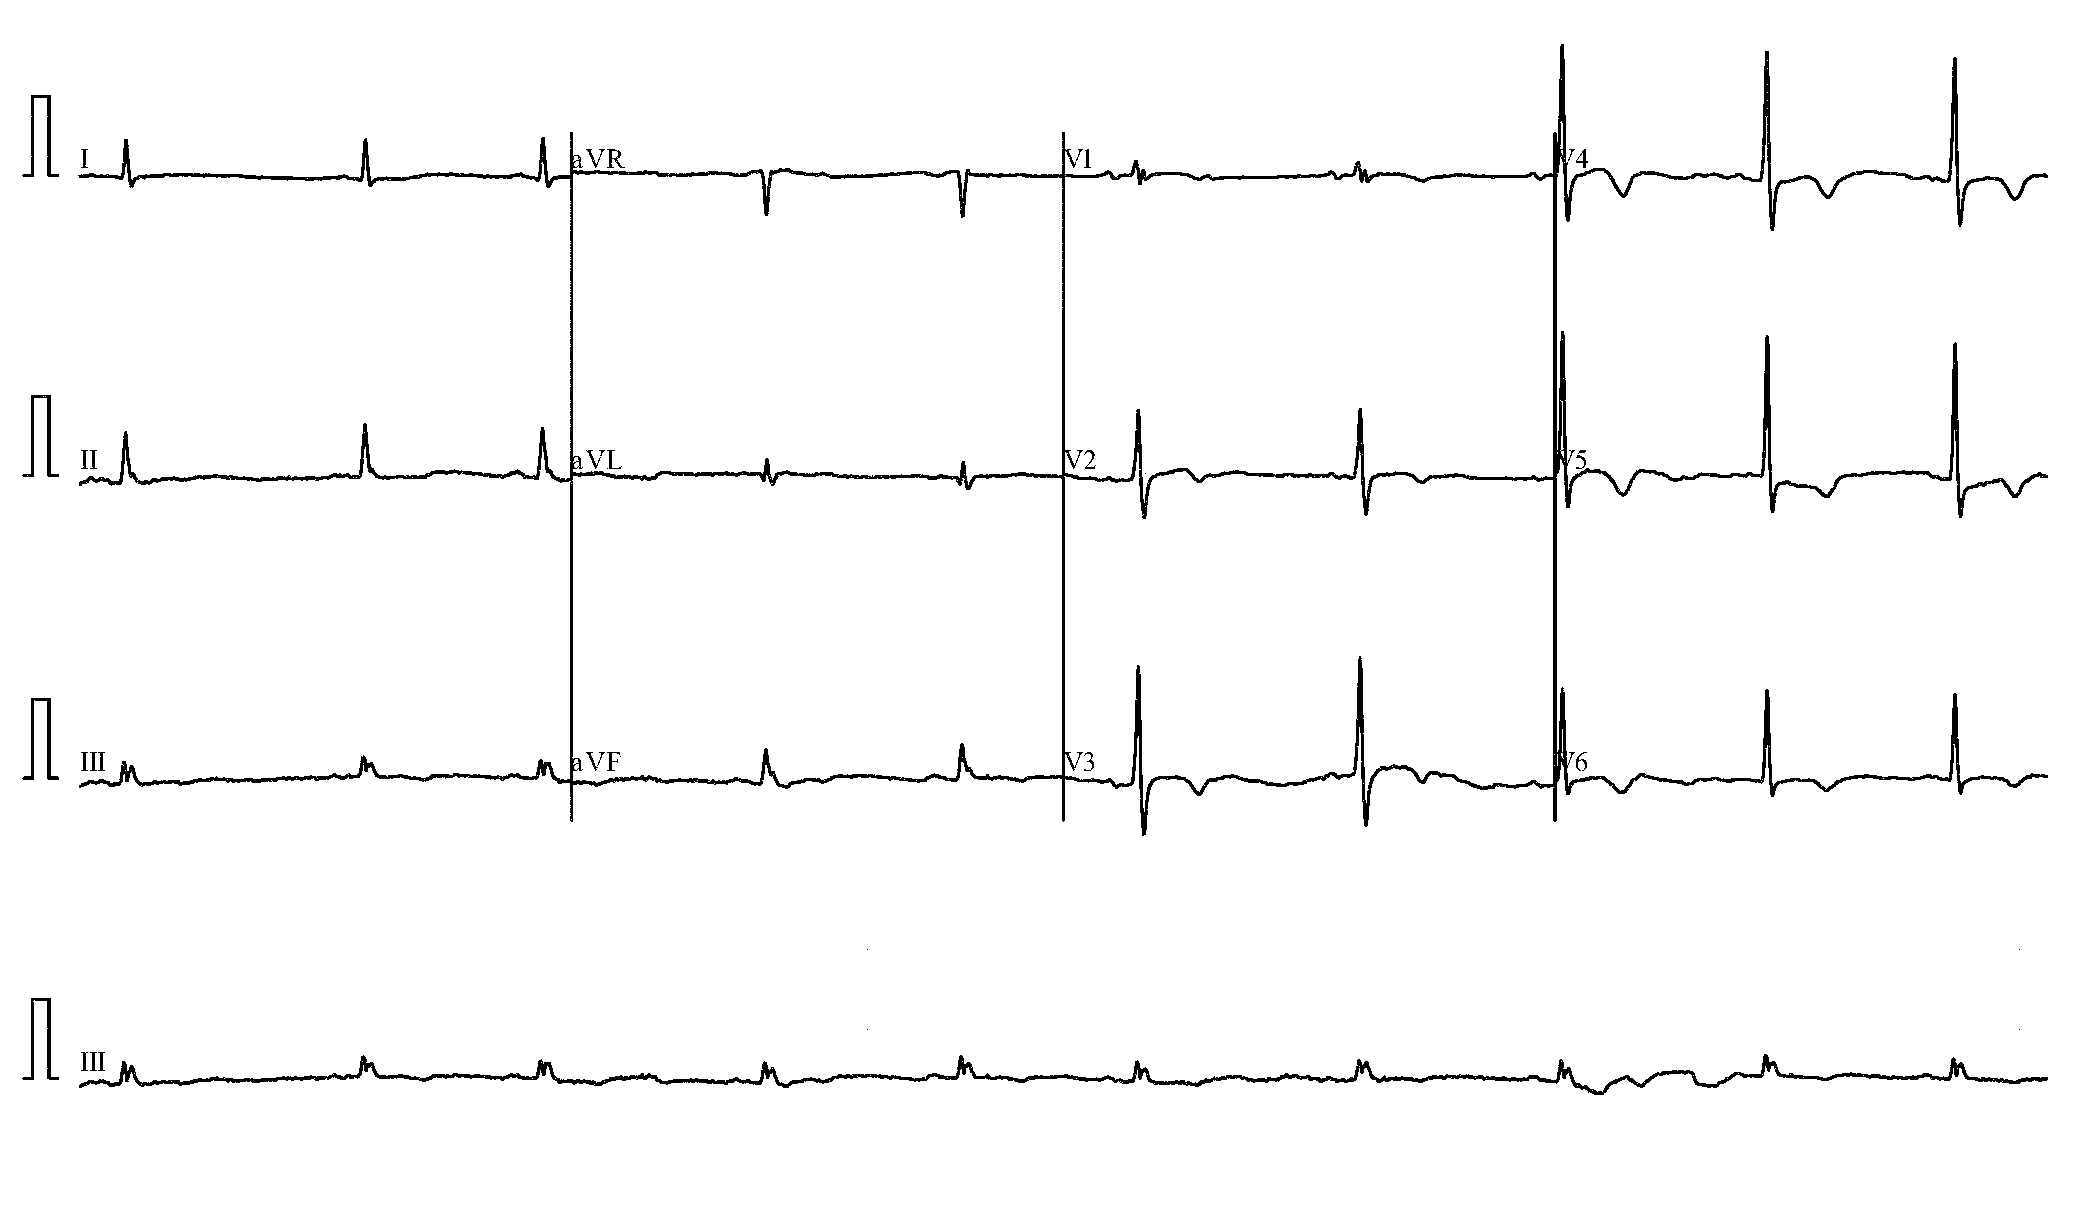

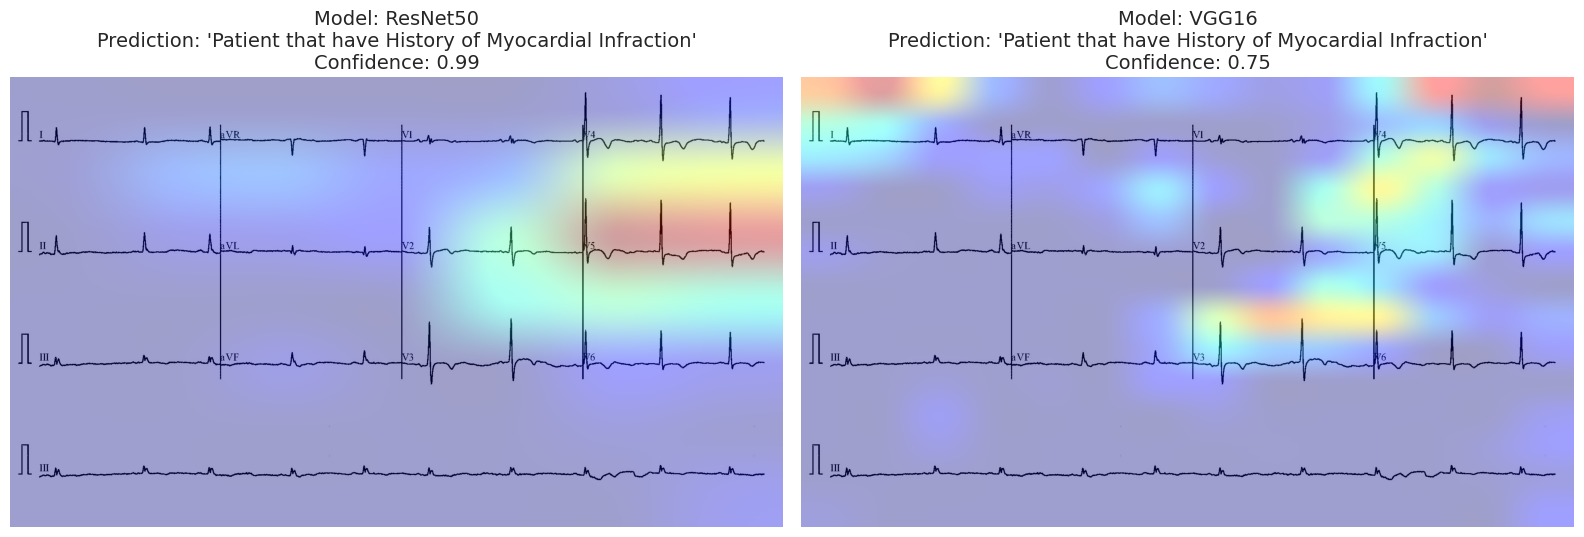

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import cv2
import os

# --- GRAD-CAM SETTINGS ---

# 1. Set how many top models you want to visualize
TOP_N_MODELS_TO_VISUALIZE = 2 # <-- Set this to 2, 3, or any number

# 2. This dictionary MUST contain the layer names for ALL models you trained
LAST_CONV_LAYER_NAMES = {
    'VGG16': 'block5_conv3',
    'ResNet50': 'conv5_block3_out',
    'InceptionV3': 'mixed10',
    'EfficientNetB2': 'top_conv',
    'EfficientNetB4': 'top_conv'
}

# 3. Automatically select the top N models based on accuracy
print(f"Automatically selecting top {TOP_N_MODELS_TO_VISUALIZE} models based on test accuracy...")

MODELS_TO_VISUALIZE = []
if 'report_data' in locals() and report_data:
    # Sort the models by 'Accuracy' in descending order
    sorted_models = sorted(report_data, key=lambda x: x['Accuracy'], reverse=True)

    # Get the names of the top N models
    top_model_names = [model['Model'] for model in sorted_models[:TOP_N_MODELS_TO_VISUALIZE]]

    # Ensure these models have a corresponding layer name defined
    for model_name in top_model_names:
        if model_name in LAST_CONV_LAYER_NAMES:
            MODELS_TO_VISUALIZE.append(model_name)
        else:
            print(f"Warning: Model '{model_name}' is a top model, but its 'last_conv_layer_name' is not defined in LAST_CONV_LAYER_NAMES. It will be skipped.")

    print(f"Selected models for visualization: {MODELS_TO_VISUALIZE}")


# --- GRAD-CAM HELPER FUNCTIONS ---
# (The functions get_img_array, make_gradcam_heatmap, and create_gradcam_overlay
#  go here without any changes)

def get_img_array(img_path, size):
    """
    Loads and transforms an image into a NumPy array suitable for the model.
    """
    img = keras.utils.load_img(img_path, target_size=size, color_mode="grayscale")
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array_1ch, model, last_conv_layer_name):
    """
    Creates a Grad-CAM heatmap using the robust, two-stage approach.
    """
    adapter_layer = model.layers[1]
    base_model = model.layers[2]
    head_layers = model.layers[3:]
    grad_model = keras.models.Model(
        inputs=[base_model.input],
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )
    with tf.GradientTape() as tape:
        img_array_3ch = adapter_layer(img_array_1ch)
        conv_outputs, base_model_output = grad_model(img_array_3ch)
        preds = base_model_output
        for layer in head_layers:
            preds = layer(preds)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def create_gradcam_overlay(processed_img_path, heatmap, alpha=0.6):
    """
    Loads the processed image and returns a new image with the heatmap overlay.
    """
    img = cv2.imread(processed_img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not load image at {processed_img_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    heatmap = np.uint8(255 * heatmap)

    # Use pyplot.get_cmap() as cm.get_cmap() is deprecated
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_rgb.shape[1], img_rgb.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img_rgb
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img


# --- START VISUALIZATION (New Logic) ---
# (The rest of the visualization loop goes here without any changes)

# 1. Find and group processed test images by class
print("Grouping processed test images by class...")
processed_test_files_by_class = {}
processed_test_dir = os.path.join(PROCESSED_DATA_PATH, 'test')

if os.path.exists(processed_test_dir):
    for class_name in os.listdir(processed_test_dir):
        class_dir = os.path.join(processed_test_dir, class_name)
        if not os.path.isdir(class_dir) or class_name not in CLASS_NAMES:
            continue

        files_in_class = []
        for filename in os.listdir(class_dir):
            files_in_class.append(os.path.join(class_dir, filename))

        if files_in_class:
            processed_test_files_by_class[class_name] = files_in_class

    print(f"Found test images for {len(processed_test_files_by_class)} classes.")
else:
    print(f"ERROR: Processed test directory not found at: {processed_test_dir}")

# 2. Loop through each class and pick one image for comparison
num_models = len(MODELS_TO_VISUALIZE)

if num_models == 0:
    print("\nNo models selected for visualization. Please check your settings.")
else:
    for class_name in CLASS_NAMES:
        if class_name not in processed_test_files_by_class:
            print(f"\nSkipping class '{class_name}': No test images found.")
            continue

        # Pick one random image from this class
        processed_path = random.choice(processed_test_files_by_class[class_name])

        print(f"\n{'='*25} ANALYSIS FOR CLASS: '{class_name}' {'='*25}")
        print(f"Analyzing image: {os.path.basename(processed_path)}")

        # Display the original processed image
        display(Image(processed_path, width=400))

        # Create a subplot for side-by-side comparison
        fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 8))

        # Handle case of single model
        if num_models == 1:
            axes = [axes]

        # 3. Generate a heatmap for each model for this single image
        for i, model_name in enumerate(MODELS_TO_VISUALIZE):
            ax = axes[i]

            try:
                # Get model details
                model = results[model_name]['model']
                last_conv_layer_name = LAST_CONV_LAYER_NAMES[model_name]
                img_size = MODELS_TO_TRAIN[model_name]

                # Prepare image and get prediction
                img_array = get_img_array(processed_path, size=(img_size, img_size))
                preds = model.predict(img_array, verbose=0)
                predicted_class_index = np.argmax(preds[0])
                predicted_class_name = CLASS_NAMES[predicted_class_index]
                confidence = preds[0][predicted_class_index]

                # Generate heatmap
                heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

                # Create overlay
                overlay_image = create_gradcam_overlay(processed_path, heatmap)

                # Plot the overlay
                if overlay_image:
                    ax.imshow(overlay_image)

                title = (
                    f"Model: {model_name}\n"
                    f"Prediction: '{predicted_class_name}'\n"
                    f"Confidence: {confidence:.2f}"
                )
                ax.set_title(title, fontsize=14)
                ax.axis('off')

            except Exception as e:
                print(f"Error processing {model_name} for image {processed_path}: {e}")
                ax.set_title(f"Error processing {model_name}")
                ax.axis('off')

        plt.tight_layout()
        plt.show()